In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt
from scipy.signal import savgol_filter

In [50]:
# Read the cleaned data CSV file
cleaned_df = pd.read_csv('../data/clean_SSTEMP_sensor.csv')

# Read the raw data CSV file
raw_df = pd.read_csv('../data/raw_SSTEMP.csv')

#Read mean target estimation method
mean_df = pd.read_csv('../data/mean_method.csv')

#Read AES target estimation method
aes_df = pd.read_csv('../data/AES_method.csv')

#Format time colums
cleaned_df['Time'] = pd.to_datetime(cleaned_df['Time'])
raw_df['Time'] = pd.to_datetime(raw_df['Time'])
mean_df['Time'] = pd.to_datetime(mean_df['Time'])
aes_df['Time'] = pd.to_datetime(aes_df['Time'])


In [51]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6216 entries, 0 to 6215
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   State   6216 non-null   float64       
 1   Time    6216 non-null   datetime64[ns]
 2   Device  6216 non-null   object        
 3   Unit    6216 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 194.4+ KB


In [52]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6216 entries, 0 to 6215
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   State   6216 non-null   float64       
 1   Time    6216 non-null   datetime64[ns]
 2   Device  6216 non-null   object        
 3   Unit    6216 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 194.4+ KB


In [53]:
mean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6206 entries, 0 to 6205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Target  6206 non-null   float64       
 1   Time    6206 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.1 KB


In [54]:
aes_df.head()

,Target,Time
0,12.838755,2024-09-12 01:10:21
1,12.734920,2024-09-12 01:10:46
2,12.707871,2024-09-12 01:11:11
3,12.701333,2024-09-12 01:11:36
4,12.700292,2024-09-12 01:12:01


In [55]:
cleaned_df = cleaned_df[1900:2000]
raw_df = raw_df[1900:2000]
mean_df = mean_df[1890:1990]
aes_df = aes_df[1890:1990]

In [56]:
holt_model = Holt(cleaned_df['State'], initialization_method="estimated")

# Fit the model with the smoothing parameters α and β (you can tune them as needed)
holt_fit = holt_model.fit(smoothing_level=0.8, smoothing_trend=0.2)

# Get the forecast values
cleaned_df['Holts'] = holt_fit.fittedvalues

# Display the new dataframe with the forecast
cleaned_df.head()

,State,Time,Device,Unit,Holts
1900,20.809632,2024-09-12 14:35:13,SSTEMP_sensor,C,20.835623
1901,20.925779,2024-09-12 14:35:38,SSTEMP_sensor,C,20.860702
1902,21.115467,2024-09-12 14:36:03,SSTEMP_sensor,C,20.969048
1903,21.189280,2024-09-12 14:36:28,SSTEMP_sensor,C,21.165895
1904,21.189280,2024-09-12 14:36:53,SSTEMP_sensor,C,21.268056


In [74]:
# Assuming 'cleaned_df' has a 'State' column

# Apply the Savitzky-Golay filter
# window_length must be an odd integer and >= polynomial_order + 2
window_length = 23
polynomial_order = 3 

# Apply the filter to the 'State' column
cleaned_df['SavitzkyGolay'] = savgol_filter(cleaned_df['State'], window_length, polynomial_order)

# Display the new dataframe with the smoothed data
cleaned_df.head()

,State,Time,Device,Unit,Holts,SavitzkyGolay
1900,20.809632,2024-09-12 14:35:13,SSTEMP_sensor,C,20.835623,20.747436
1901,20.925779,2024-09-12 14:35:38,SSTEMP_sensor,C,20.860702,20.924134
1902,21.115467,2024-09-12 14:36:03,SSTEMP_sensor,C,20.969048,21.064635
1903,21.189280,2024-09-12 14:36:28,SSTEMP_sensor,C,21.165895,21.171029
1904,21.189280,2024-09-12 14:36:53,SSTEMP_sensor,C,21.268056,21.245408


In [75]:
#get all MSE's
mse_mean = mean_squared_error(cleaned_df['State'], mean_df['Target'])
mse_aes = mean_squared_error(cleaned_df['State'], aes_df['Target'])
mse_holts = mean_squared_error(cleaned_df['State'], cleaned_df['Holts']);
mse_golay = mean_squared_error(cleaned_df['State'], cleaned_df['SavitzkyGolay'])

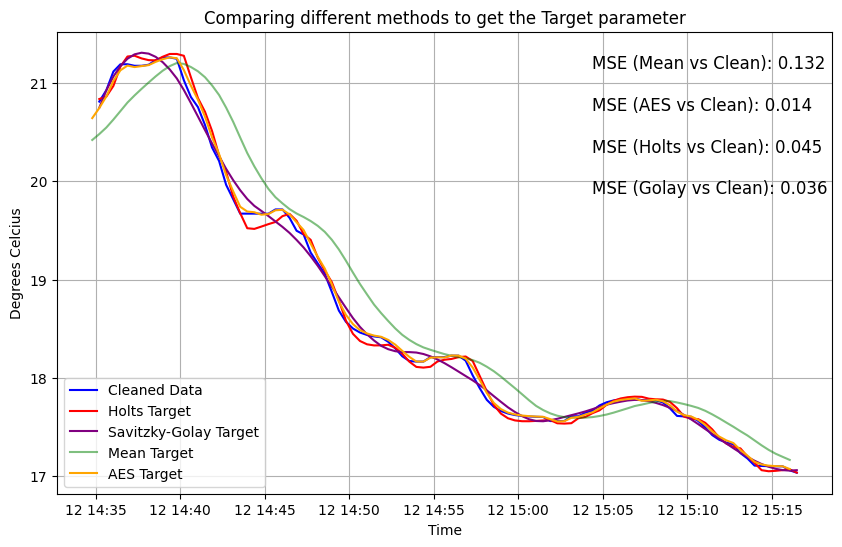

In [79]:
plt.figure(figsize=(10,6))

# Plot cleaned data
plt.plot(cleaned_df['Time'], cleaned_df['State'], label='Cleaned Data', color='blue')

# Plot the Holts target data
plt.plot(cleaned_df['Time'], cleaned_df['Holts'], label='Holts Target', color='red')

# Plot the Savitzky-Golay target data
plt.plot(cleaned_df['Time'], cleaned_df['SavitzkyGolay'], label='Savitzky-Golay Target', color='purple')

# Plot raw data
#plt.plot(raw_df['Time'], raw_df['State'], label='Raw Data', color='red', alpha=0.5)

# Plot mean target data
plt.plot(mean_df['Time'], mean_df['Target'], label='Mean Target', color='green', alpha=0.5)

# Plot aes target data
plt.plot(aes_df['Time'], aes_df['Target'], label='AES Target', color='orange')

# Add R-squared values to the plot
plt.text(0.69, 0.95, f'MSE (Mean vs Clean): {mse_mean:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.69, 0.86, f'MSE (AES vs Clean): {mse_aes:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.69, 0.77, f'MSE (Holts vs Clean): {0.045:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.69, 0.68, f'MSE (Golay vs Clean): {0.036:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Degrees Celcius')
plt.title('Comparing different methods to get the Target parameter')
plt.legend()
plt.grid(True)

plt.show()